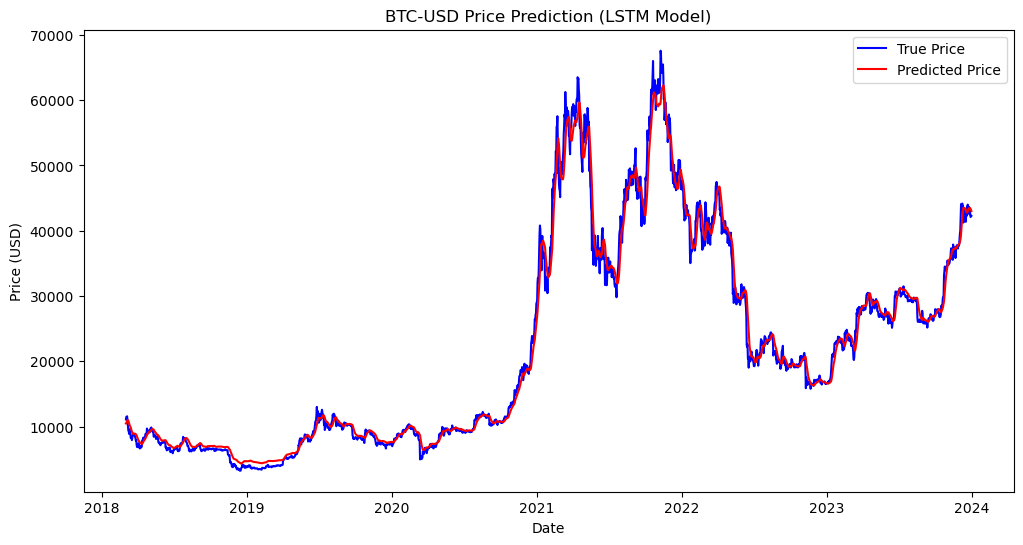

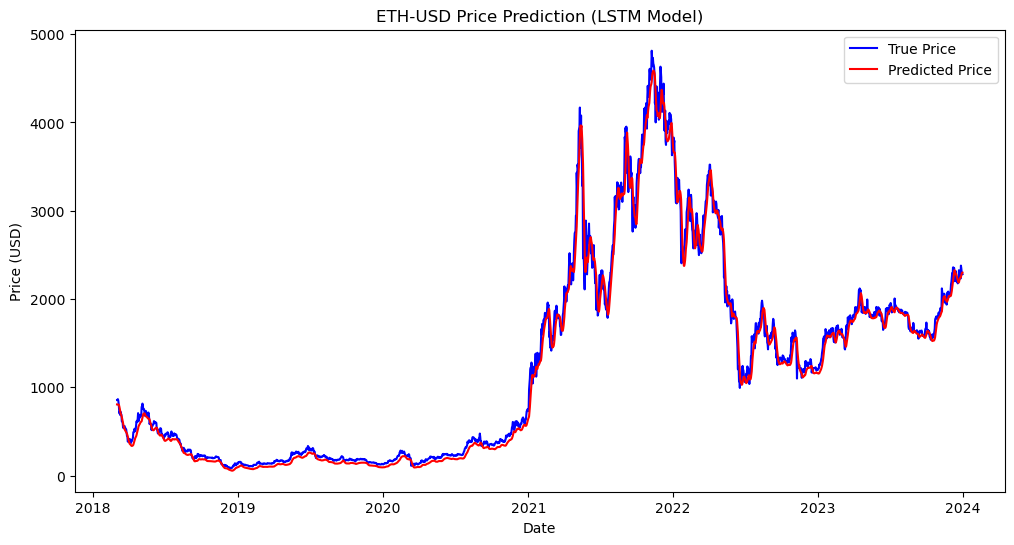

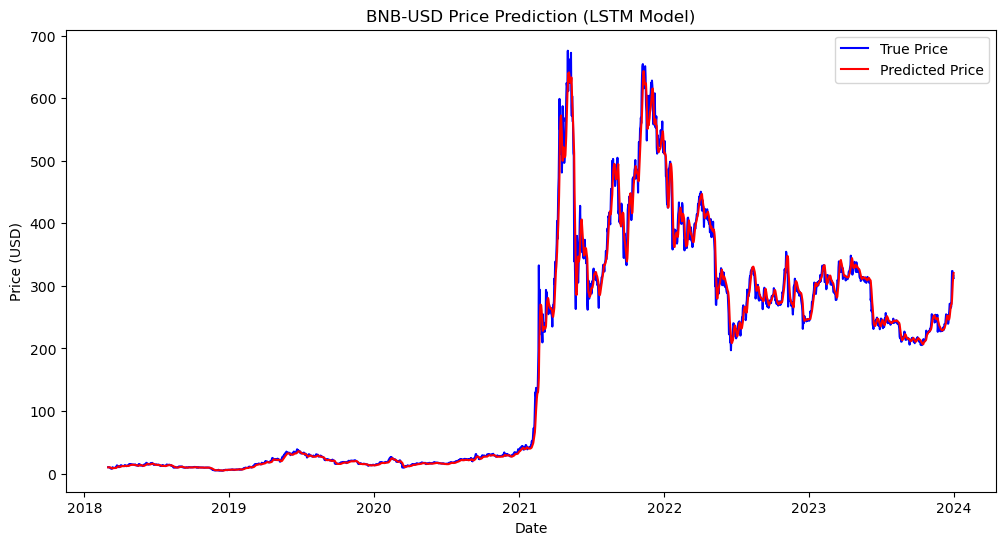

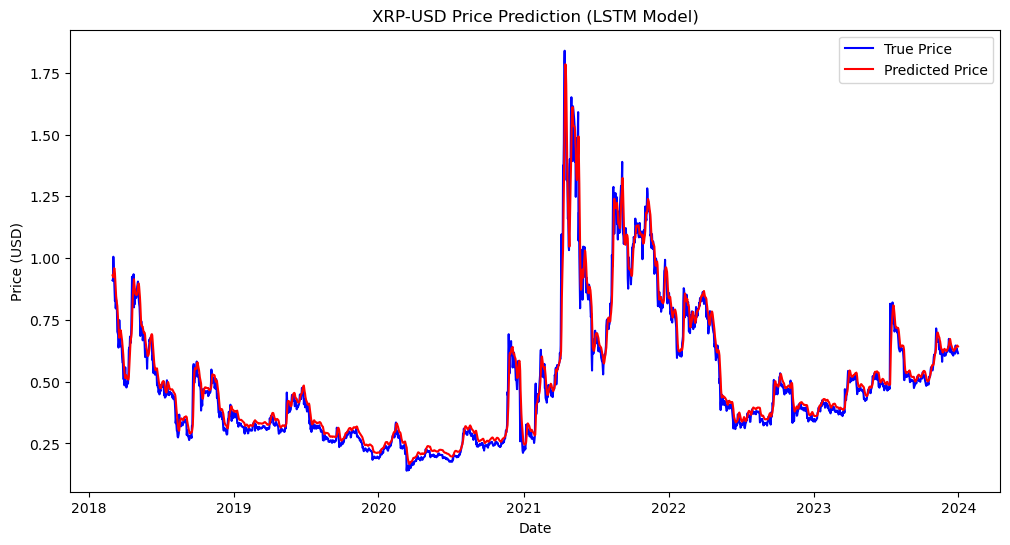

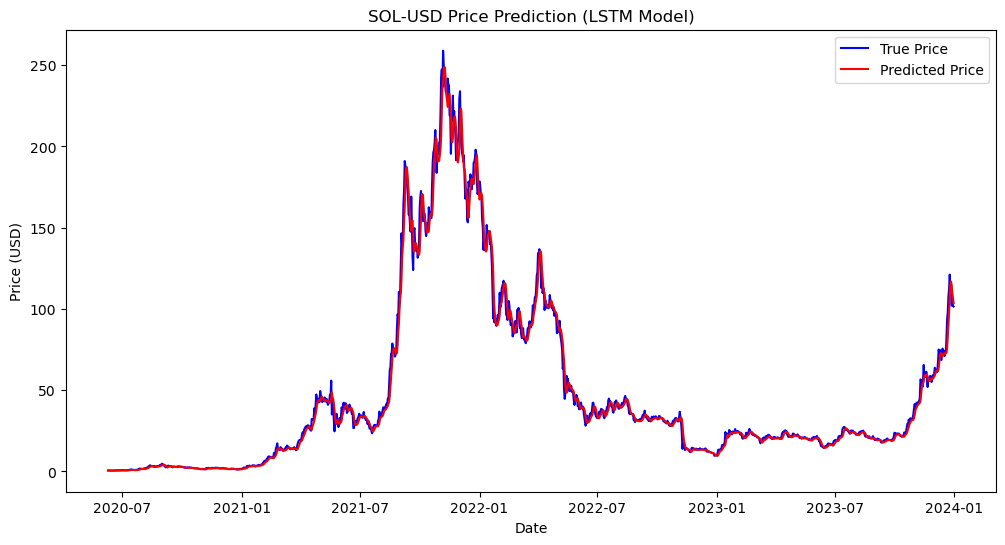

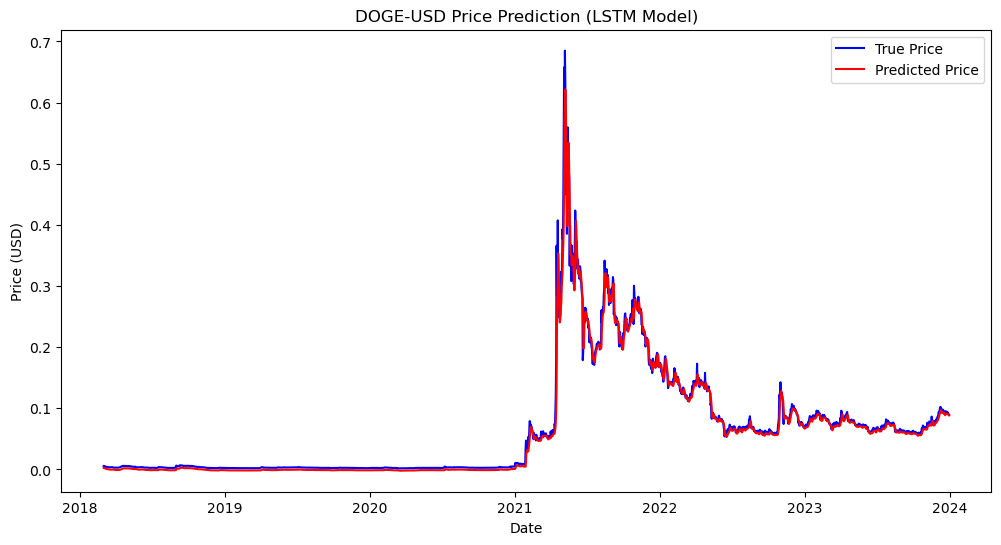

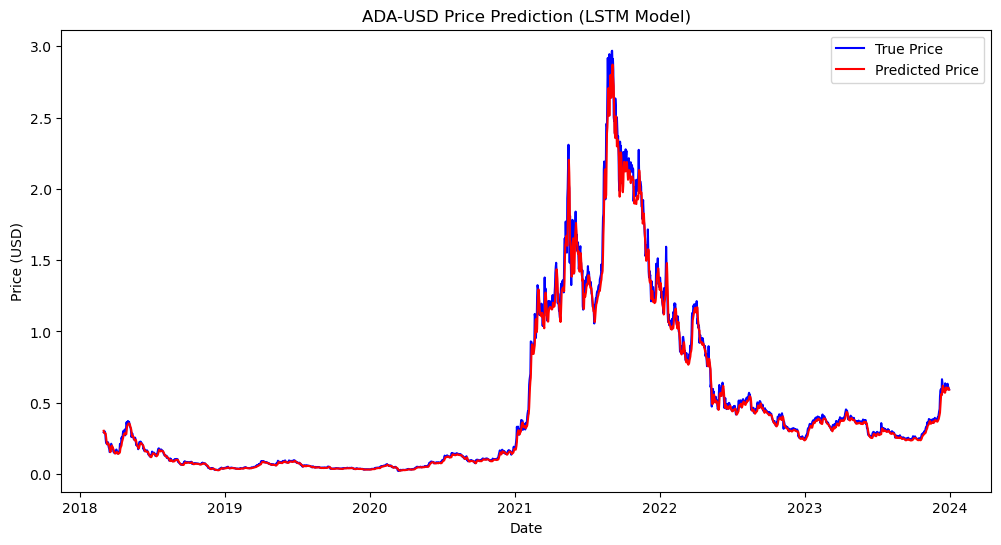

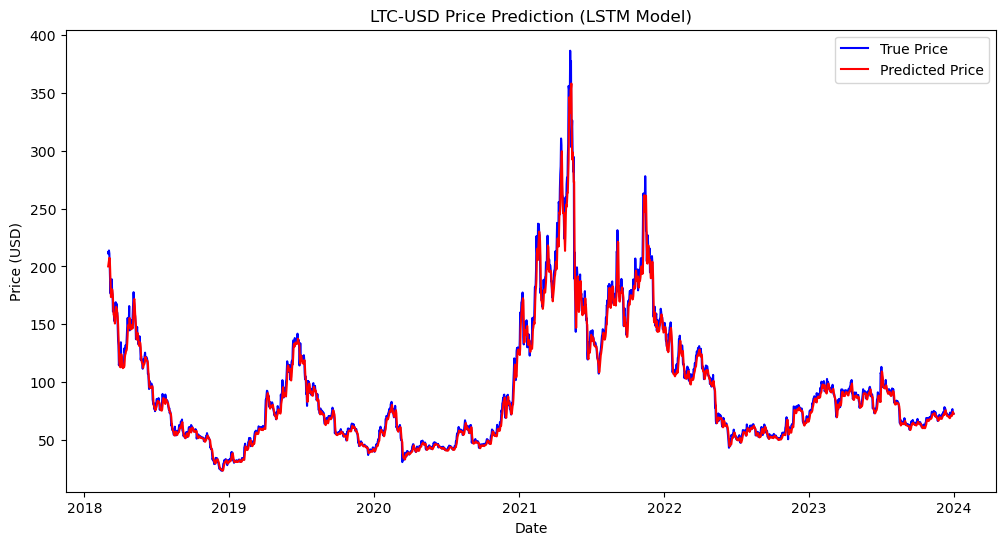

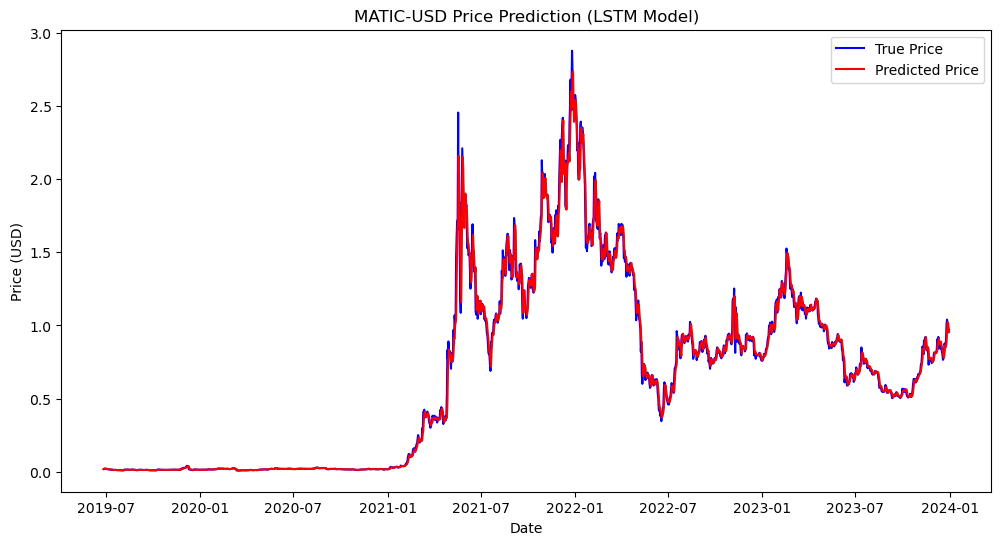

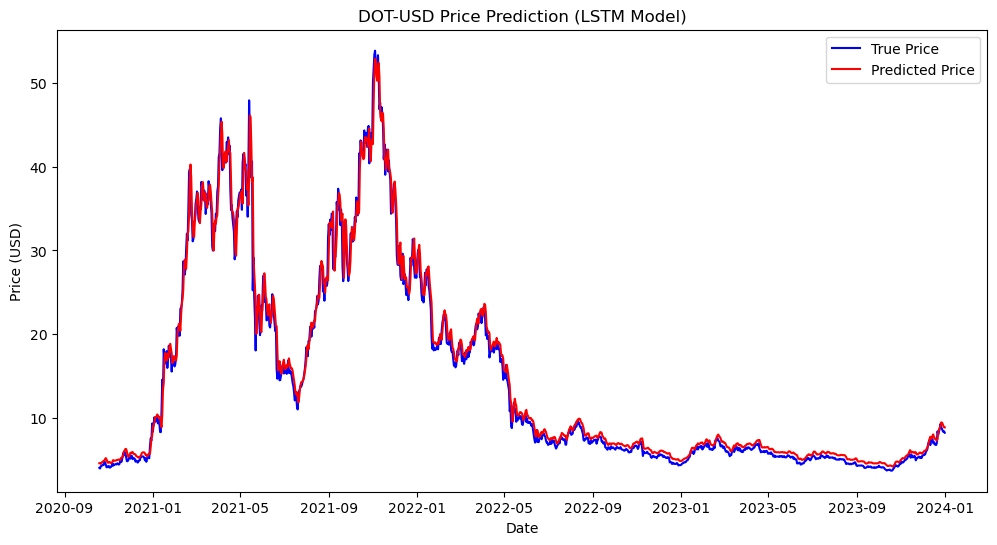

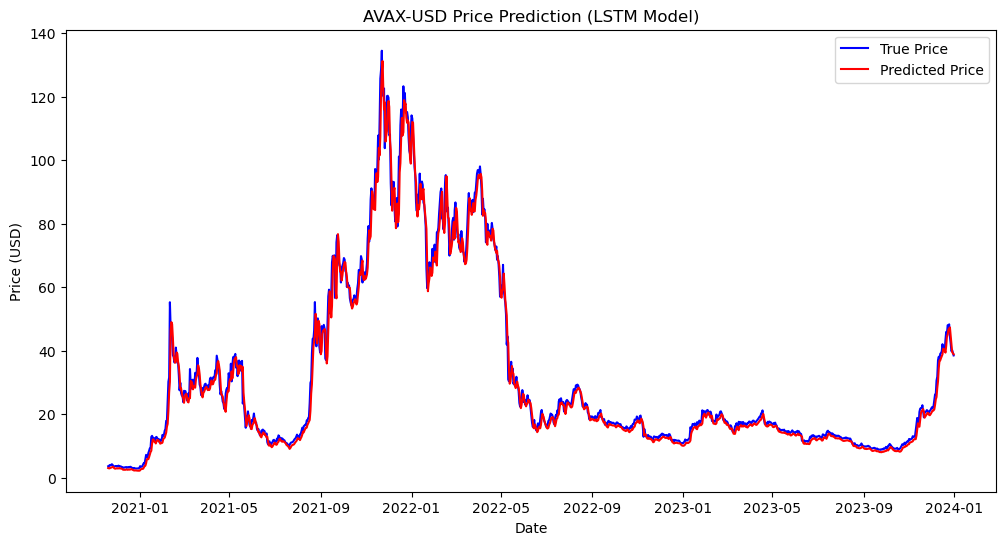

   Cryptocurrency Pair         RMSE
0              BTC-USD  1691.254289
1              ETH-USD   117.096160
2              BNB-USD    15.229961
3              XRP-USD     0.049770
4              SOL-USD     5.445284
5             DOGE-USD     0.012599
6              ADA-USD     0.052489
7              LTC-USD     7.144295
8            MATIC-USD     0.066784
9              DOT-USD     1.359588
10            AVAX-USD     3.168606


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.metrics import mean_squared_error

# Define the cryptocurrency pairs
symbols = [
    'BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'SOL-USD', 'DOGE-USD', 'ADA-USD', 'LTC-USD',
    'MATIC-USD', 'DOT-USD', 'AVAX-USD'
]



# Function to download data and preprocess it
def preprocess_data(symbol, start_date='2018-01-01', end_date='2024-01-01'):
    df = yf.download(symbol, start=start_date, end=end_date,progress=False)
    data = df[['Close']].dropna()

    # Rescale the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    # Prepare the dataset
    def create_dataset(data, window_size=60):
        X, y = [], []
        for i in range(window_size, len(data)):
            X.append(data[i - window_size:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    window_size = 60
    X, y = create_dataset(data_scaled, window_size)
    
    # Reshape X to be 3D for LSTM input
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Convert to torch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Create DataLoader for batch processing
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    return X_tensor, y_tensor, dataloader, scaler, df

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1, :])  # Get the last time step
        return predictions

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size=1, hidden_layer_size=50, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# RMSE results storage
rmse_results = []

# Loop over each cryptocurrency pair
for symbol in symbols:
    # Step 1: Preprocess data
    X_tensor, y_tensor, dataloader, scaler, df = preprocess_data(symbol)

    # Step 2: Train the model
    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Step 3: Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor).squeeze().numpy()

    # Rescale predictions and actual values back to the original scale
    predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_rescaled = scaler.inverse_transform(y_tensor.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_rescaled, predictions_rescaled))
    rmse_results.append((symbol, rmse))

    # Step 4: Plot results for the cryptocurrency
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[60:], y_rescaled, label='True Price', color='blue')
    plt.plot(df.index[60:], predictions_rescaled, label='Predicted Price', color='red')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title(f'{symbol} Price Prediction (LSTM Model)')
    plt.legend()
    plt.show()

# Step 5: Display RMSE results in a table
rmse_df = pd.DataFrame(rmse_results, columns=['Cryptocurrency Pair', 'RMSE'])
print(rmse_df)


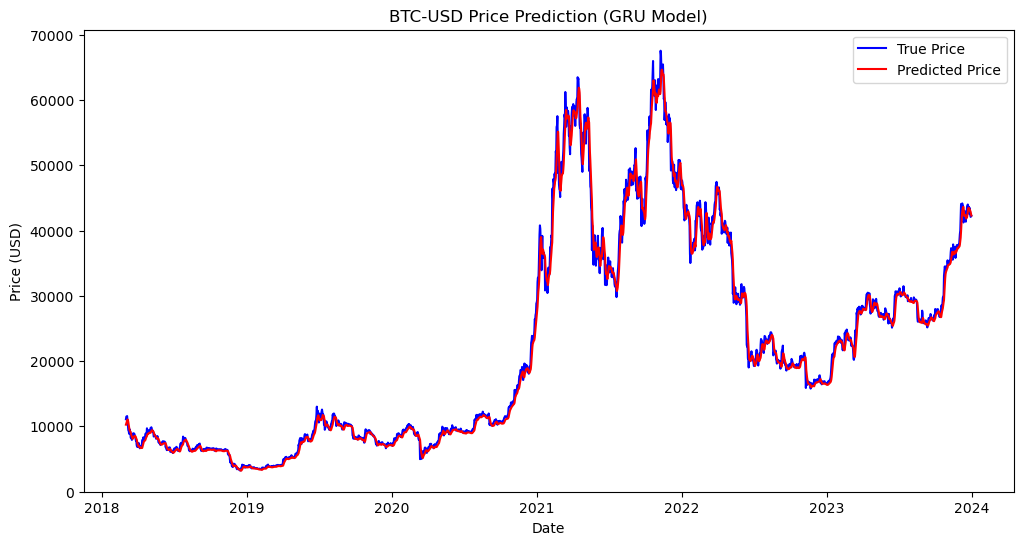

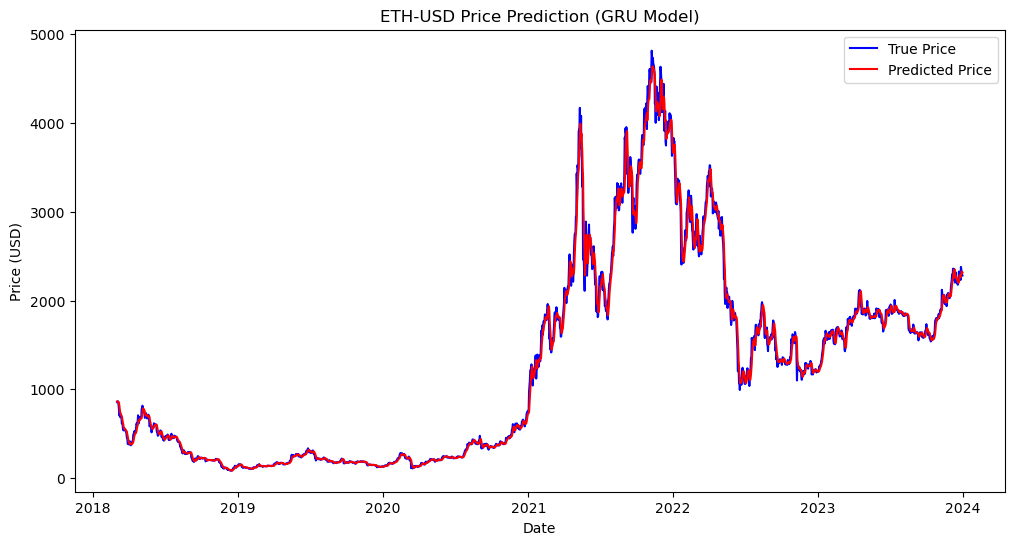

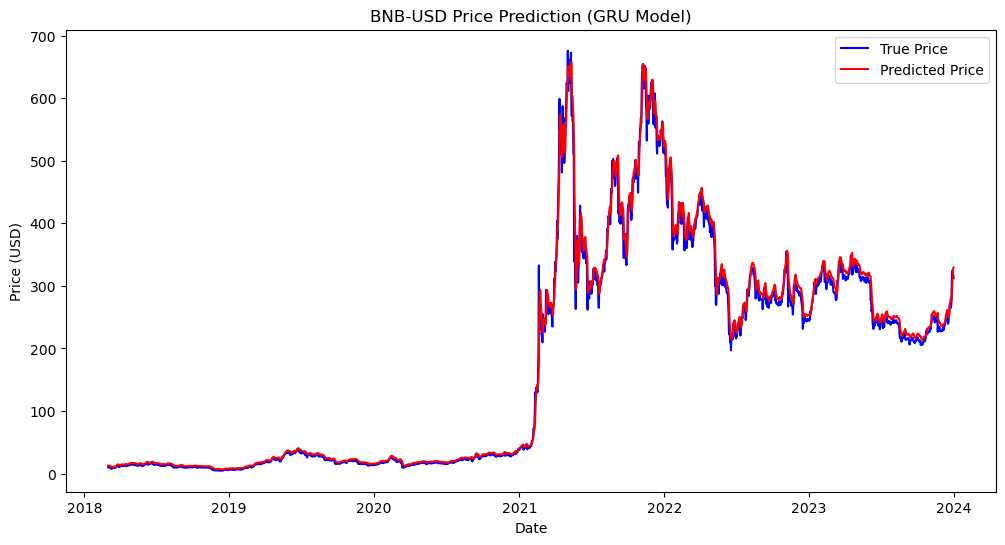

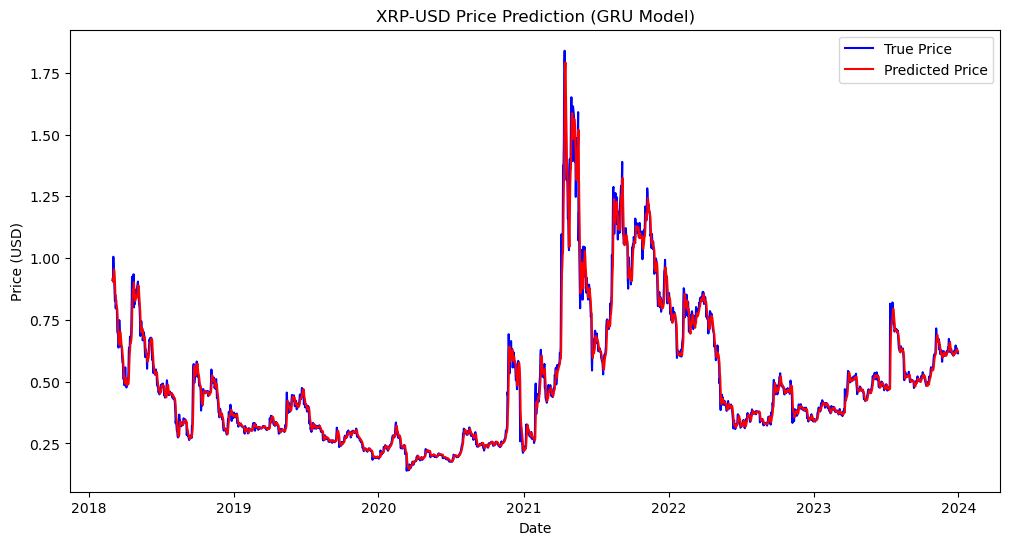

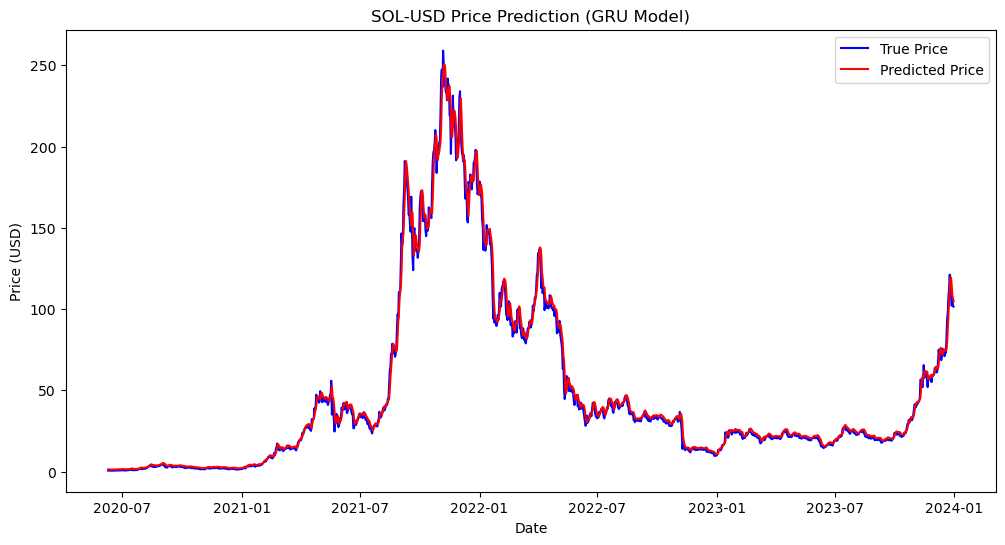

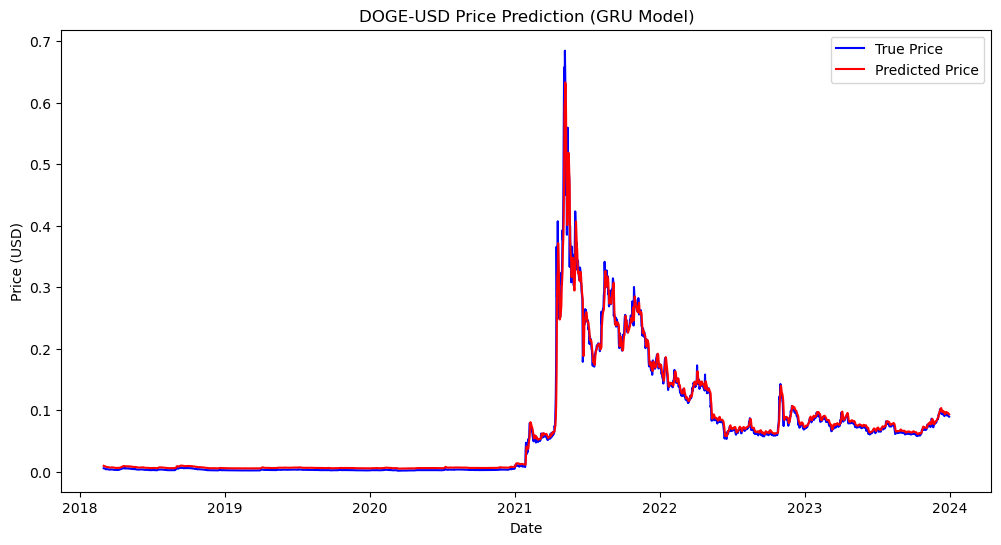

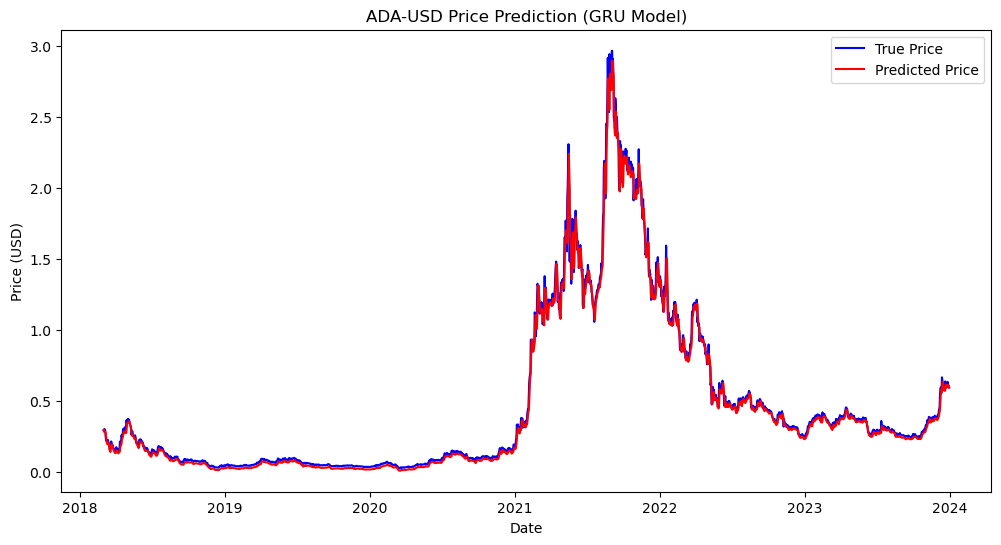

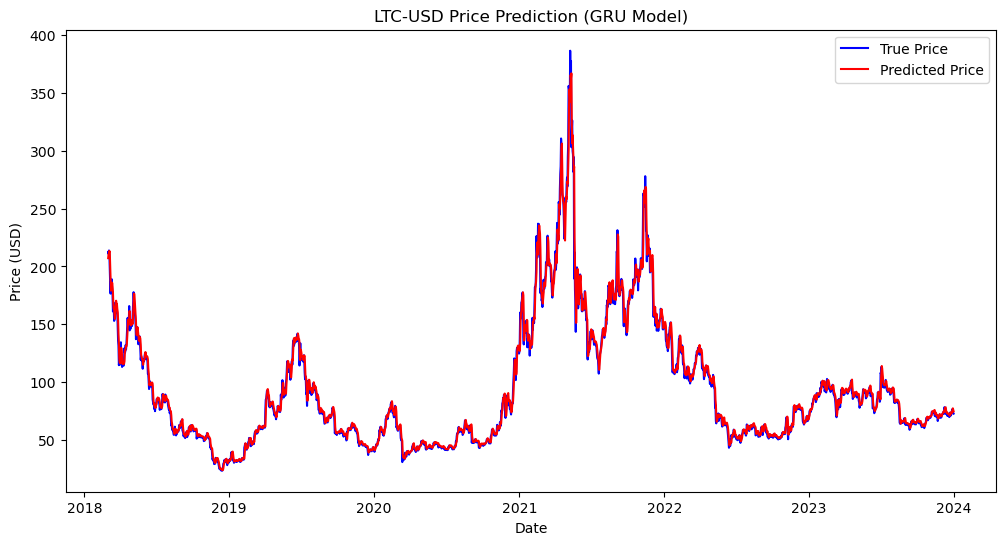

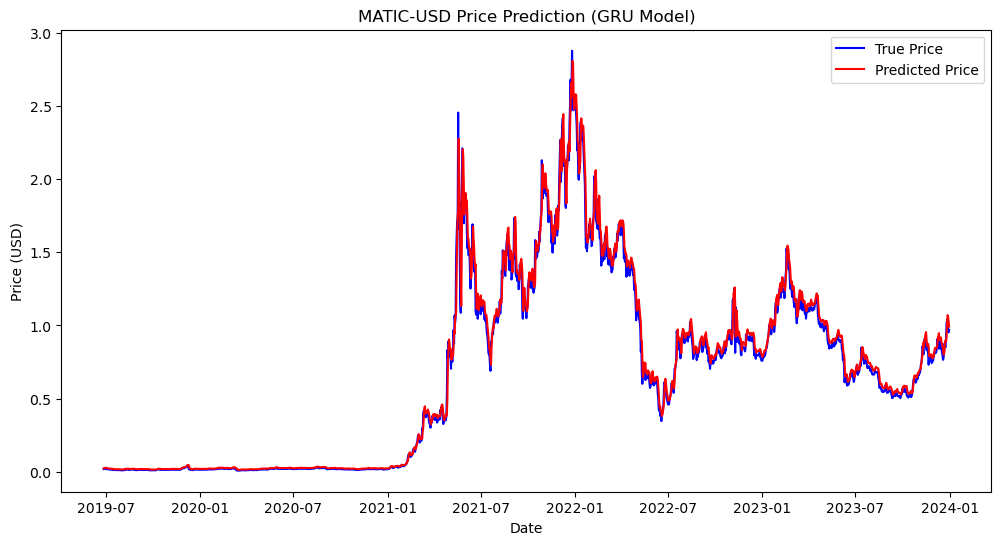

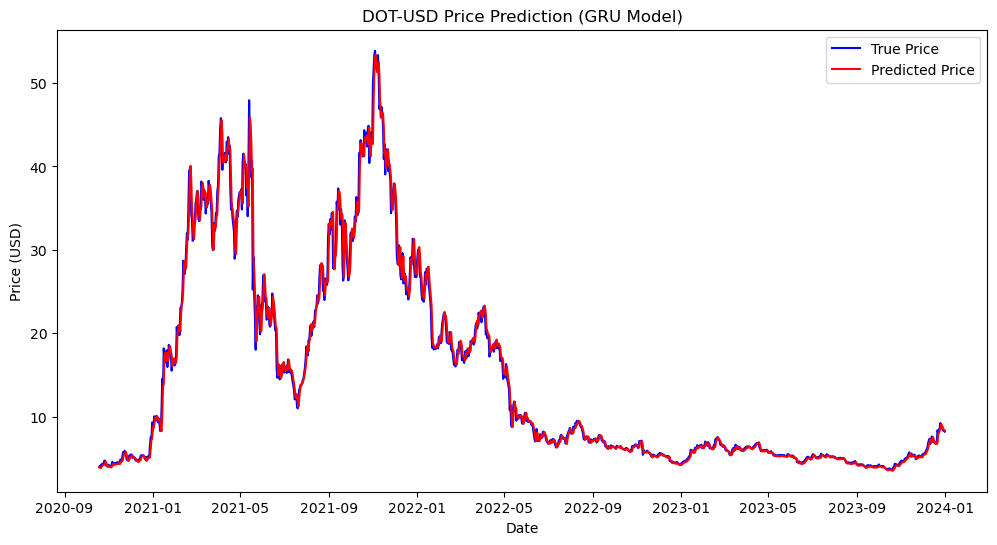

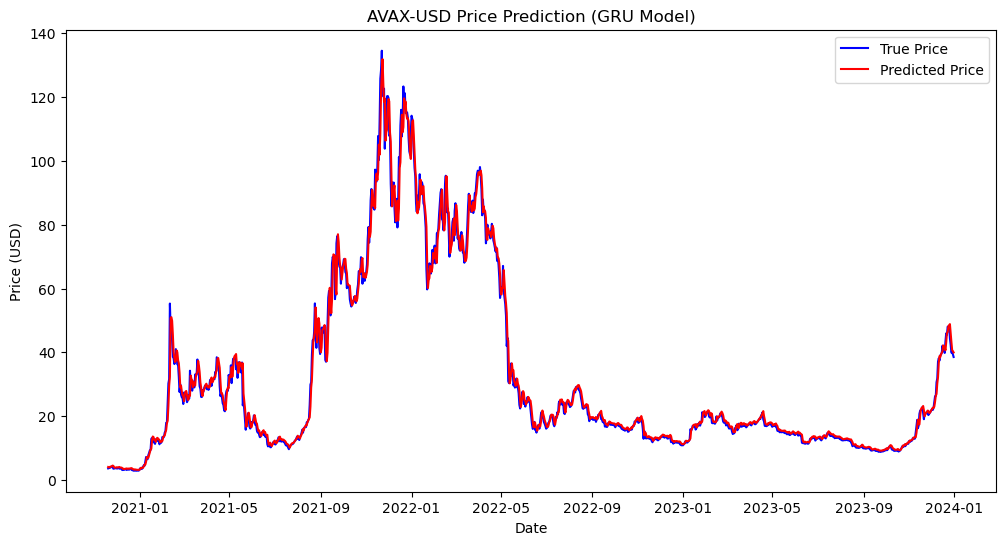

   Cryptocurrency Pair         RMSE
0              BTC-USD  1293.416826
1              ETH-USD    89.954339
2              BNB-USD    14.688709
3              XRP-USD     0.041985
4              SOL-USD     4.956018
5             DOGE-USD     0.012006
6              ADA-USD     0.049922
7              LTC-USD     6.656316
8            MATIC-USD     0.071095
9              DOT-USD     1.289088
10            AVAX-USD     2.987179


In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.metrics import mean_squared_error

# Define the cryptocurrency pairs
symbols = [
    'BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'SOL-USD', 'DOGE-USD', 'ADA-USD', 'LTC-USD',
    'MATIC-USD', 'DOT-USD', 'AVAX-USD'
]

# Function to download data and preprocess it
def preprocess_data(symbol, start_date='2018-01-01', end_date='2024-01-01'):
    df = yf.download(symbol, start=start_date, end=end_date, progress=False)
    data = df[['Close']].dropna()

    # Rescale the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    # Prepare the dataset
    def create_dataset(data, window_size=60):
        X, y = [], []
        for i in range(window_size, len(data)):
            X.append(data[i - window_size:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    window_size = 60
    X, y = create_dataset(data_scaled, window_size)
    
    # Reshape X to be 3D for GRU input
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Convert to torch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Create DataLoader for batch processing
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    return X_tensor, y_tensor, dataloader, scaler, df

# Define the GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        predictions = self.fc(gru_out[:, -1, :])  # Get the last time step
        return predictions

# Initialize model, loss function, and optimizer
model = GRUModel(input_size=1, hidden_layer_size=50, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# RMSE results storage
rmse_results = []

# Loop over each cryptocurrency pair
for symbol in symbols:
    # Step 1: Preprocess data
    X_tensor, y_tensor, dataloader, scaler, df = preprocess_data(symbol)

    # Step 2: Train the model
    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Step 3: Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor).squeeze().numpy()

    # Rescale predictions and actual values back to the original scale
    predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_rescaled = scaler.inverse_transform(y_tensor.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_rescaled, predictions_rescaled))
    rmse_results.append((symbol, rmse))

    # Step 4: Plot results for the cryptocurrency
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[60:], y_rescaled, label='True Price', color='blue')
    plt.plot(df.index[60:], predictions_rescaled, label='Predicted Price', color='red')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title(f'{symbol} Price Prediction (GRU Model)')
    plt.legend()
    plt.show()

# Step 5: Display RMSE results in a table
rmse_df = pd.DataFrame(rmse_results, columns=['Cryptocurrency Pair', 'RMSE'])
print(rmse_df)


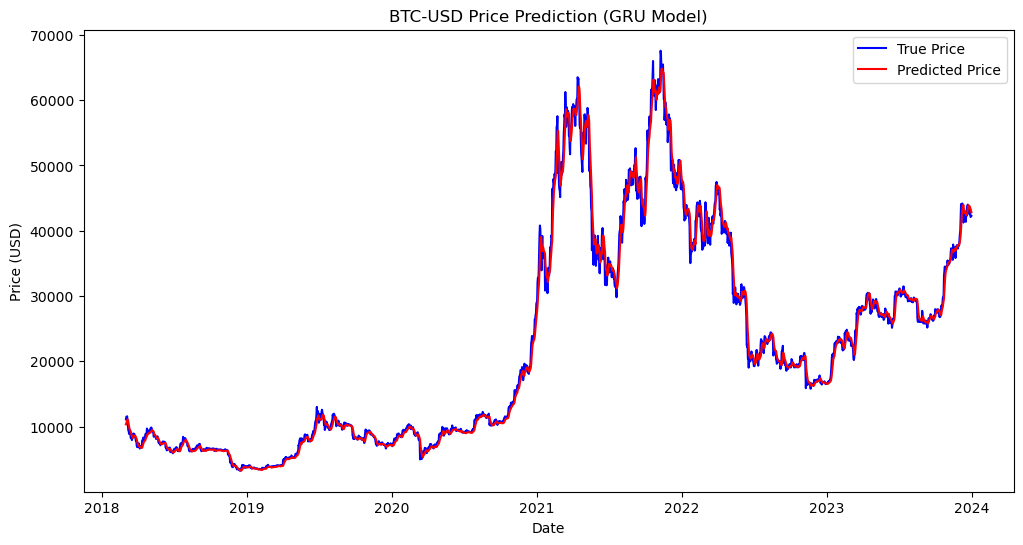

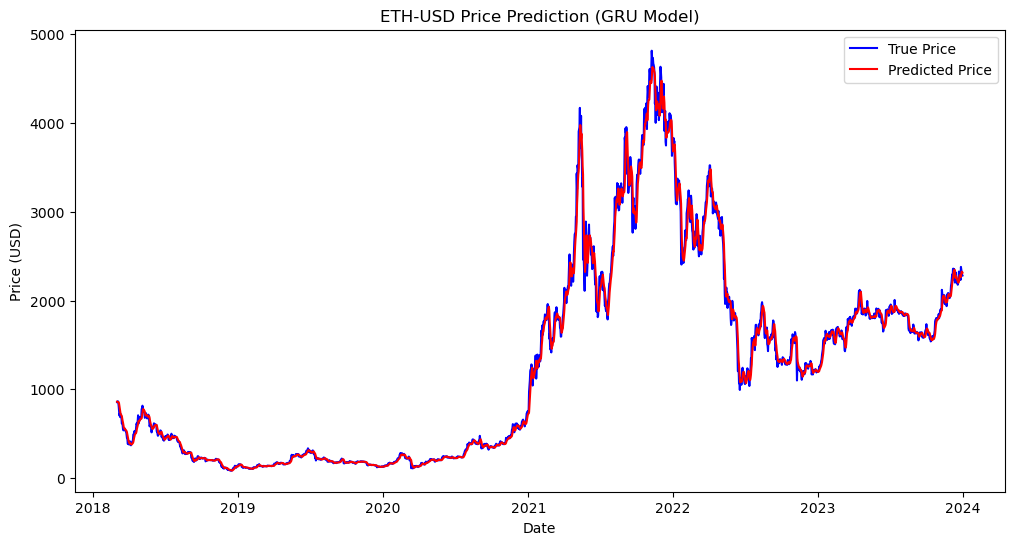

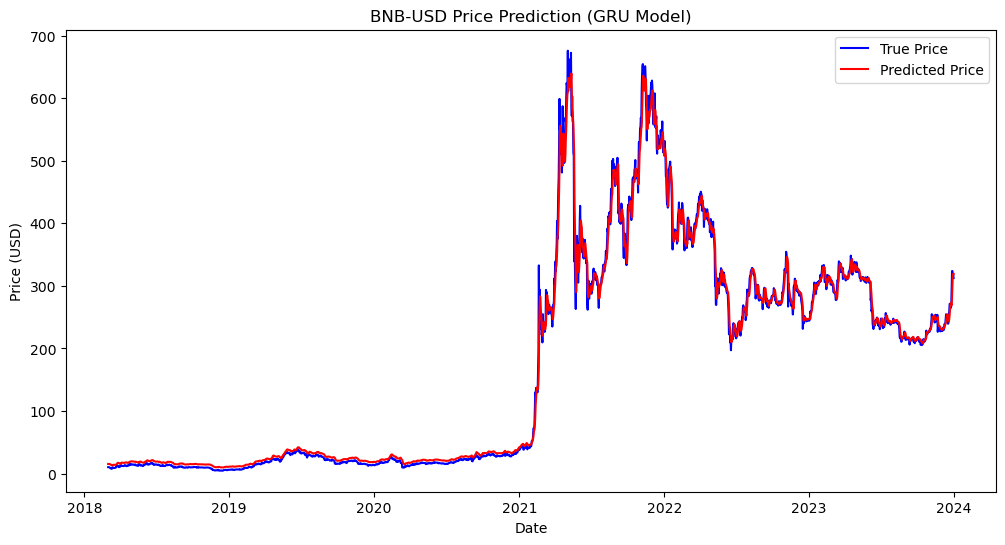

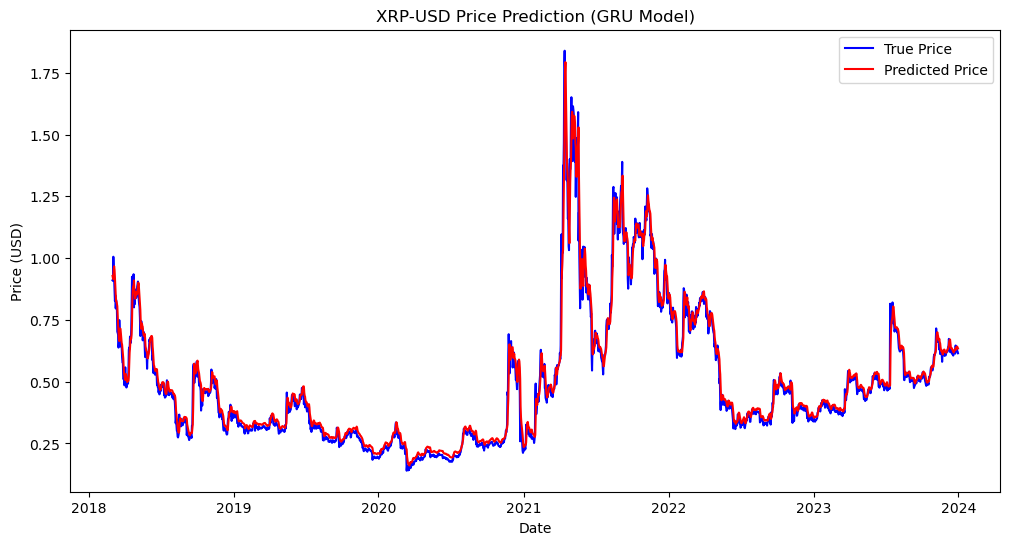

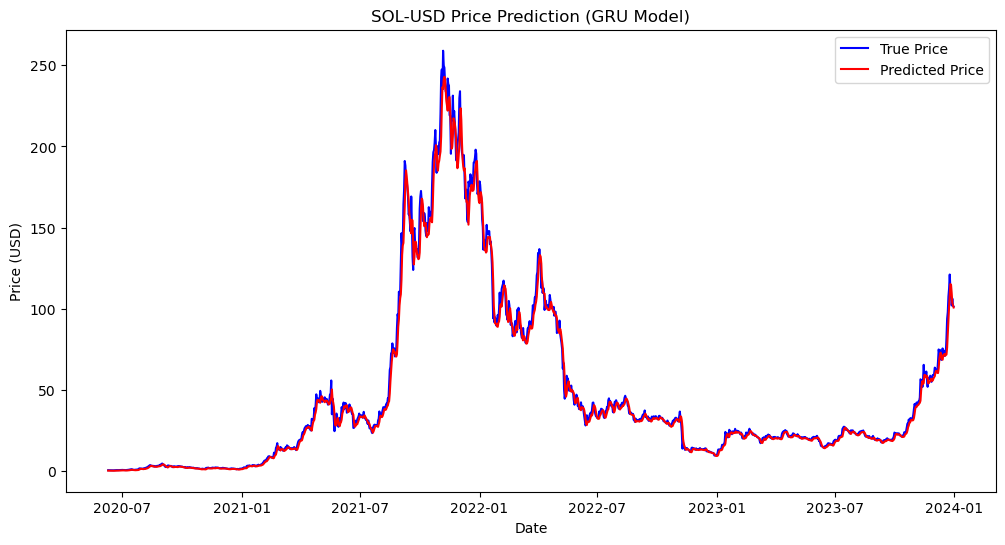

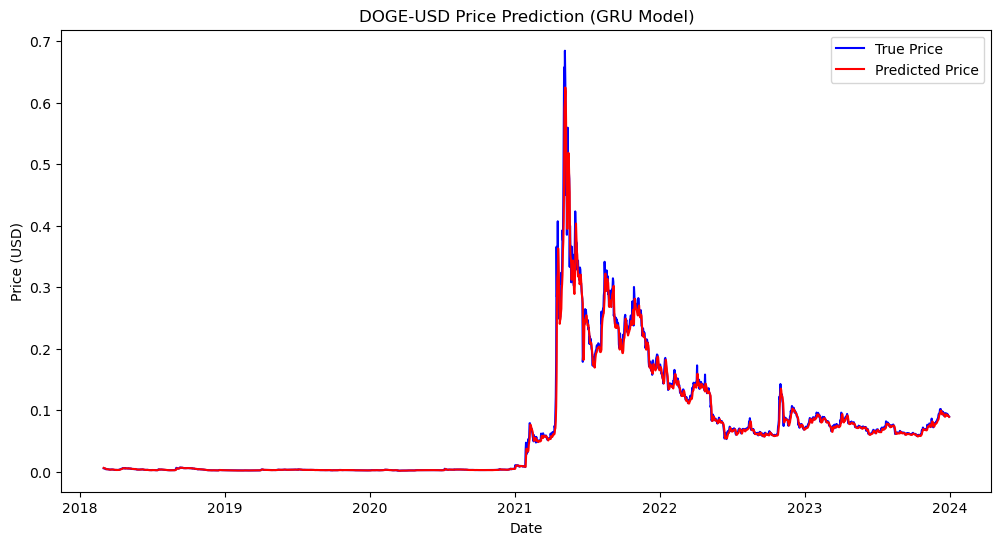

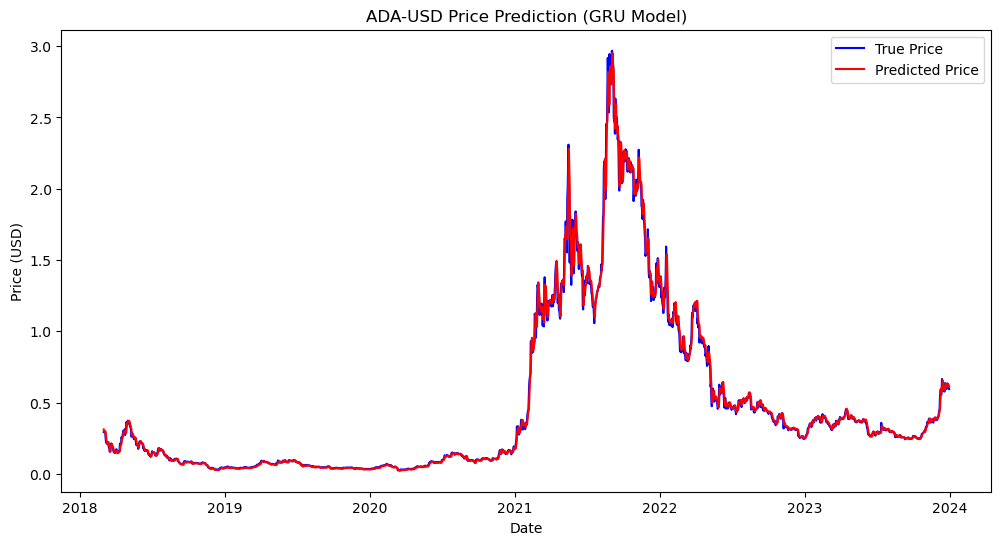

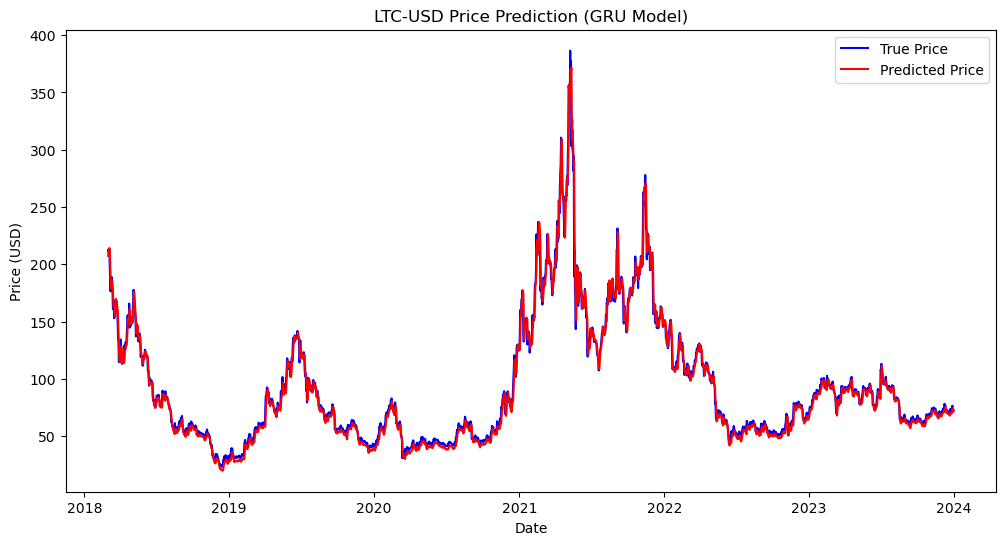

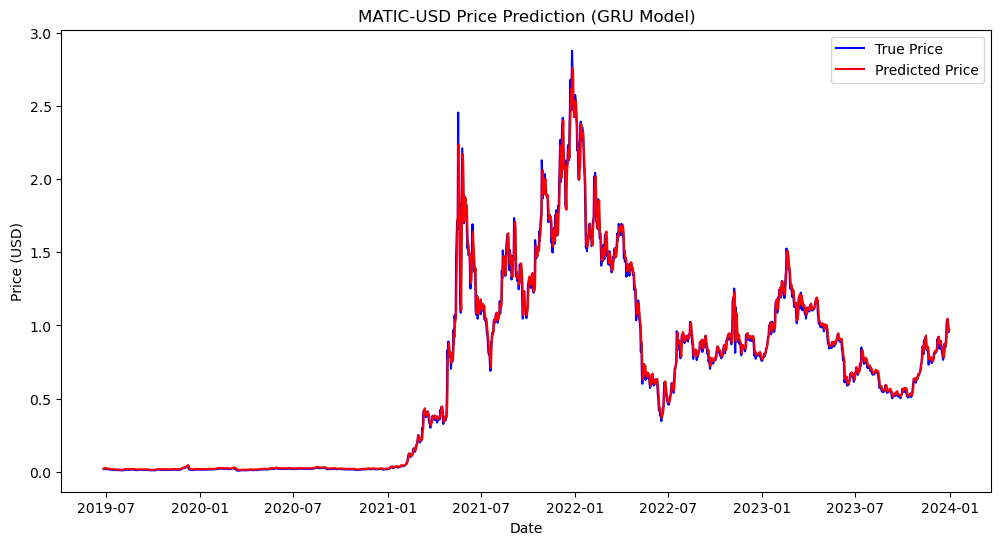

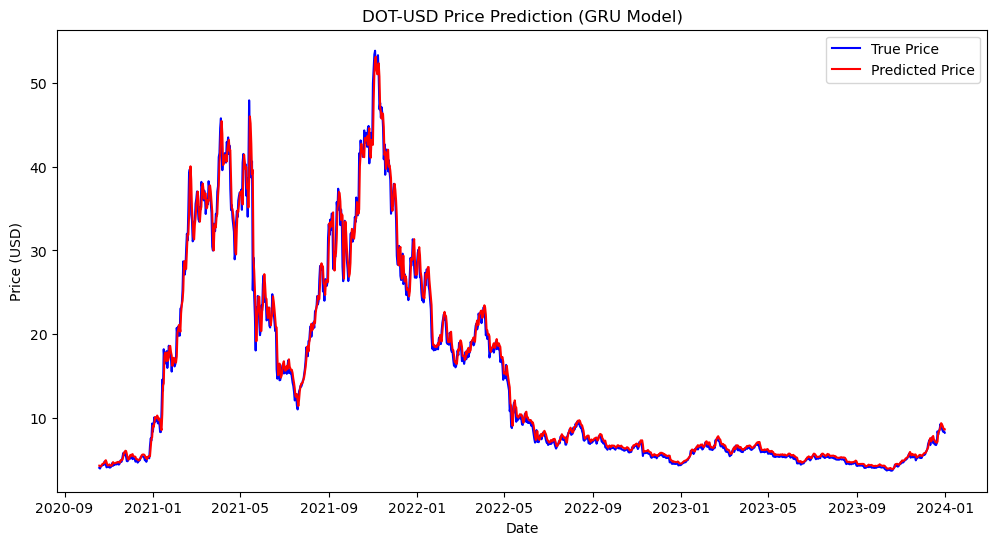

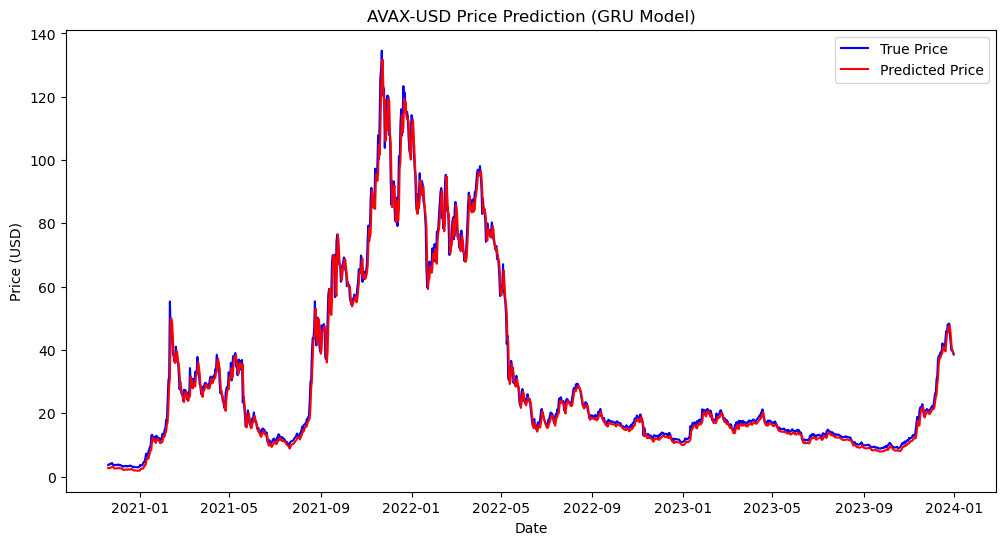

   Cryptocurrency Pair         RMSE
0              BTC-USD  1307.122125
1              ETH-USD    90.942625
2              BNB-USD    13.806663
3              XRP-USD     0.043274
4              SOL-USD     5.118861
5             DOGE-USD     0.011839
6              ADA-USD     0.046583
7              LTC-USD     6.940091
8            MATIC-USD     0.066209
9              DOT-USD     1.296127
10            AVAX-USD     3.098761


In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.metrics import mean_squared_error

# Define the cryptocurrency pairs
symbols = [
    'BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'SOL-USD', 'DOGE-USD', 'ADA-USD', 'LTC-USD',
    'MATIC-USD', 'DOT-USD', 'AVAX-USD'
]

# Function to download data and preprocess it
def preprocess_data(symbol, start_date='2018-01-01', end_date='2024-01-01'):
    df = yf.download(symbol, start=start_date, end=end_date, progress=False)
    data = df[['Close']].dropna()

    # Rescale the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    # Prepare the dataset
    def create_dataset(data, window_size=60):
        X, y = [], []
        for i in range(window_size, len(data)):
            X.append(data[i - window_size:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    window_size = 60
    X, y = create_dataset(data_scaled, window_size)
    
    # Reshape X to be 3D for GRU input
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Convert to torch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Create DataLoader for batch processing
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    return X_tensor, y_tensor, dataloader, scaler, df

# Define the GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        predictions = self.fc(gru_out[:, -1, :])  # Get the last time step
        return predictions

# Initialize model, loss function, and optimizer
model = GRUModel(input_size=1, hidden_layer_size=50, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# RMSE results storage
rmse_results = []

# Loop over each cryptocurrency pair
for symbol in symbols:
    # Step 1: Preprocess data
    X_tensor, y_tensor, dataloader, scaler, df = preprocess_data(symbol)

    # Step 2: Train the model
    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Step 3: Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor).squeeze().numpy()

    # Rescale predictions and actual values back to the original scale
    predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_rescaled = scaler.inverse_transform(y_tensor.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_rescaled, predictions_rescaled))
    rmse_results.append((symbol, rmse))

    # Step 4: Plot results for the cryptocurrency
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[60:], y_rescaled, label='True Price', color='blue')
    plt.plot(df.index[60:], predictions_rescaled, label='Predicted Price', color='red')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title(f'{symbol} Price Prediction (GRU Model)')
    plt.legend()

    # Save the plot as a JPG file
    plt.savefig(f"{symbol}_price_prediction.jpg", format='jpg', dpi=300)
    plt.show()

# Step 5: Display RMSE results in a table
rmse_df = pd.DataFrame(rmse_results, columns=['Cryptocurrency Pair', 'RMSE'])
print(rmse_df)


In [11]:
!pip install nbconvert
